In [3]:
# ==============================
# Setup: Spark Session & Data Load
# ==============================
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, to_date, count, avg, date_format

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Start Spark session
spark = SparkSession.builder.appName("SIT742Assignment2").getOrCreate()

# Load CSVs
# reviews = spark.read.csv("./business_review_submission/review.csv", header=True, inferSchema=True)
# meta = spark.read.csv("./business_review_submission/meta-review-business.csv", header=True, inferSchema=True)

reviews = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .option("multiLine", "true")         # handles reviews spanning multiple lines
    .option("escape", "\"")              # handles quotes in text
    .option("mode", "PERMISSIVE")        # keep malformed rows instead of dropping
    .option("columnNameOfCorruptRecord", "_corrupt_record")  # optional: track bad rows
    .load("./business_review_submission/review.csv")
)

meta = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .option("mode", "PERMISSIVE")
    .load("./business_review_submission/meta-review-business.csv")
)

# Preview
reviews.printSchema()
meta.printSchema()


root
 |-- user_id: double (nullable = true)
 |-- name: string (nullable = true)
 |-- time: long (nullable = true)
 |-- rating: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)

root
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- description: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- category: string (nullable = true)
 |-- avg_rating: string (nullable = true)
 |-- num_of_reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- MISC: string (nullable = true)
 |-- state: string (nullable = true)
 |-- relative_results: string (nullable = true)
 |-- url: string (nullable = true)



### Q1.1

In [6]:
from pyspark.sql.functions import col, when, from_unixtime

# Replace null text with "no review"
reviews = reviews.withColumn("text", when(col("text").isNull(), "no review").otherwise(col("text")))

# Convert Unix timestamp (milliseconds) into yyyy-MM-dd
reviews = reviews.withColumn("newtime", from_unixtime((col("time")/1000).cast("bigint"), "yyyy-MM-dd"))

# Show first 5 rows
reviews.select("user_id", "name", "time", "newtime", "rating", "text", "gmap_id").show(5, truncate=False)


+---------------------+-----------------+-------------+----------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------+
|user_id              |name             |time         |newtime   |rating|text                                                                  

### Q1.2

In [7]:
from pyspark.sql.functions import count

# Count number of reviews per gmap_id
review_counts = reviews.groupBy("gmap_id") \
    .agg(count("*").cast("float").alias("review_count"))

# Show top 5 rows
review_counts.show(5, truncate=False)


+-------------------------------------+------------+
|gmap_id                              |review_count|
+-------------------------------------+------------+
|0x56c8977642a793f5:0xab9f95aa9c585a46|27.0        |
|0x56c79c63a5af15e3:0x117ca44b9578b995|10.0        |
|0x56c8976e16705e63:0x787e5d94ea9d2387|49.0        |
|0x51325aac7a4434e5:0xfbed5197982b41ae|28.0        |
|0x56c6631e32190947:0x7620b39117ffbb62|12.0        |
+-------------------------------------+------------+
only showing top 5 rows



In [8]:
import pandas as pd

# Convert Spark DataFrame into Pandas
pdf = reviews.select("gmap_id", "time", "newtime", "text", "rating").toPandas()

# Convert Unix time (ms) into datetime
pdf["datetime"] = pd.to_datetime(pdf["time"], unit="ms", errors="coerce")

# Extract hour as review_time
pdf["review_time"] = pdf["datetime"].dt.hour

# Show first 5 rows
pdf.head()


gmap_id           time     newtime  \
0  0x56b646ed2220b77f:0xd8975e316de80952  1566331951619  2019-08-20   
1  0x56b646ed2220b77f:0xd8975e316de80952  1504917982385  2017-09-09   
2  0x56b646ed2220b77f:0xd8975e316de80952  1474765901185  2016-09-25   
3  0x56b646ed2220b77f:0xd8975e316de80952  1472858535682  2016-09-02   
4  0x56b646ed2220b77f:0xd8975e316de80952  1529649811341  2018-06-22   

                                                text  rating  \
0  We always stay here when in Valdez for silver ...       5   
1  Great campground for the price. Nice hot unlim...       5   
2  We tent camped here for 2 nights while explori...       4   
3  This place is just a few miles outside Valdez,...       4   
4  Probably the nicest and cleanest campground we...       5   

                 datetime  review_time  
0 2019-08-20 20:12:31.619           20  
1 2017-09-09 00:46:22.385            0  
2 2016-09-25 01:11:41.185            1  
3 2016-09-02 23:22:15.682           23  
4 2018-06-22 06:43:31.341            6

/tmp/ipython-input-4017756486.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="review_time", data=pdf_clean, palette="viridis")


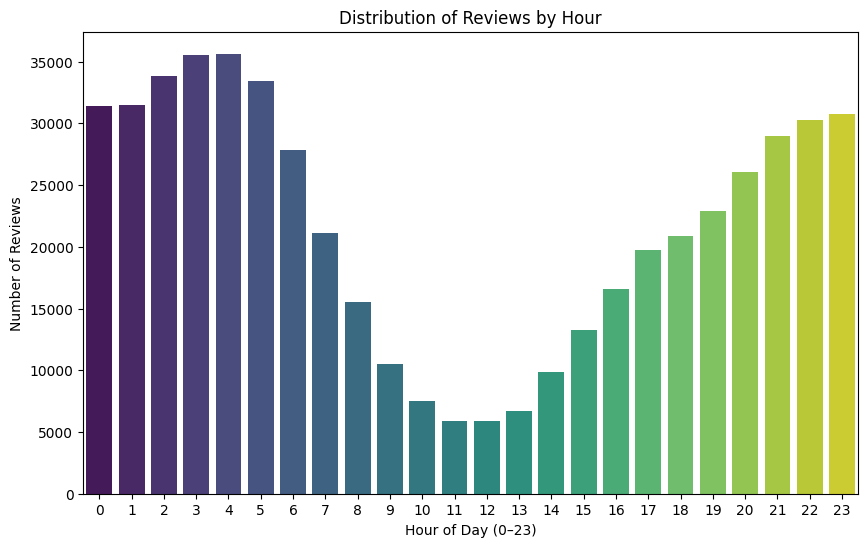

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop NaN values in review_time
pdf_clean = pdf.dropna(subset=["review_time"])

# Convert review_time to int (avoid float values like 20.0, 0.0, etc.)
pdf_clean["review_time"] = pdf_clean["review_time"].astype(int)

# Distribution of review times (hourly)
plt.figure(figsize=(10,6))
sns.countplot(x="review_time", data=pdf_clean, palette="viridis")
plt.title("Distribution of Reviews by Hour")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)  # keep hours horizontal
plt.show()



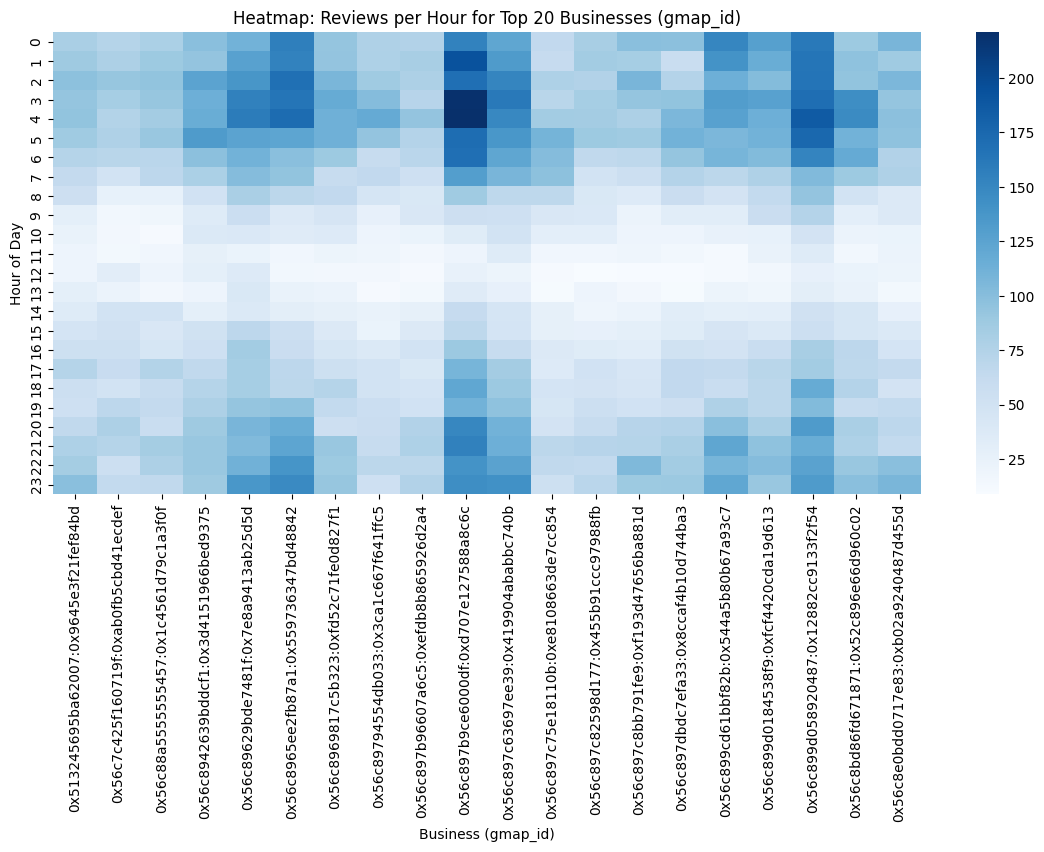

In [10]:
# Keep only rows where gmap_id looks valid (starts with '0x')
pdf_clean = pdf.dropna(subset=["review_time", "gmap_id"])
pdf_clean = pdf_clean[pdf_clean["gmap_id"].astype(str).str.startswith("0x")]

# Get top 20 businesses with most reviews
top_ids = pdf_clean["gmap_id"].value_counts().nlargest(20).index
pdf_top = pdf_clean[pdf_clean["gmap_id"].isin(top_ids)]

# Pivot for heatmap
pivot = pdf_top.pivot_table(
    index="review_time",
    columns="gmap_id",
    values="text",
    aggfunc="count",
    fill_value=0
)

plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap="Blues")
plt.title("Heatmap: Reviews per Hour for Top 20 Businesses (gmap_id)")
plt.xlabel("Business (gmap_id)")
plt.ylabel("Hour of Day")
plt.show()



### Q1.3

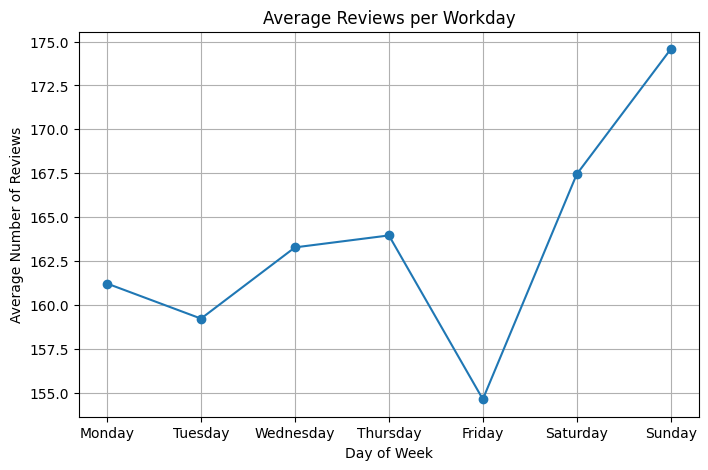



Weekday with most average reviews: Sunday


In [11]:
# 1.3.1 Average reviews per weekday

# Convert Unix ms to datetime
pdf["datetime"] = pd.to_datetime(pdf["time"], unit="ms", errors="coerce")

# Extract weekday and date
pdf["weekday"] = pdf["datetime"].dt.day_name()
pdf["date"] = pdf["datetime"].dt.date

# Count reviews per date
daily_counts = pdf.groupby(["date", "weekday"])["gmap_id"].count().reset_index()

# Average reviews per weekday
weekday_avg = daily_counts.groupby("weekday")["gmap_id"].mean().reset_index()

# Sort by weekday order
weekday_avg["weekday"] = pd.Categorical(
    weekday_avg["weekday"],
    categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
    ordered=True
)
weekday_avg = weekday_avg.sort_values("weekday")

# Plot
plt.figure(figsize=(8,5))
plt.plot(weekday_avg["weekday"], weekday_avg["gmap_id"], marker="o")
plt.title("Average Reviews per Workday")
plt.xlabel("Day of Week")
plt.ylabel("Average Number of Reviews")
plt.grid(True)
plt.show()

# Get top weekday
top_weekday = weekday_avg.loc[weekday_avg["gmap_id"].idxmax(), "weekday"]
print("\n")
print("Weekday with most average reviews:", top_weekday)


In [14]:
# 1.3.2 Top businesses on that weekday

meta_df = meta.toPandas()

# Join reviews from the top weekday with meta data
weekday_reviews = pdf[pdf["weekday"] == top_weekday].merge(meta_df, on="gmap_id", how="left")

# Compute average rating per business
top_business = (
    weekday_reviews.groupby("name")
    .agg({
        "category": lambda x: list(set(x)),  # unique categories
        "rating": "mean"
    })
    .reset_index()
    .sort_values("rating", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

print("\nTop businesses with highest average rating on", top_weekday)
print(top_business.to_string(index=False))



Top businesses with highest average rating on Sunday
                                                       name                                                                                                                                                                                                                           category  rating
                                   13 Ravens Coffee & Books                                                                                                                                                                                            [['Coffee shop', 'Book store', 'Cafe']]     5.0
🚚Eagle Towing Anchorage Girdwood Eagle River Palmer Wasilla                                                                                                                                                                                     [['Towing service', 'Transportation service']]     5.0
                                                   bodyphlo  

/tmp/ipython-input-1876621448.py:25: UserWarning: Glyph 128666 (\N{DELIVERY TRUCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128666 (\N{DELIVERY TRUCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


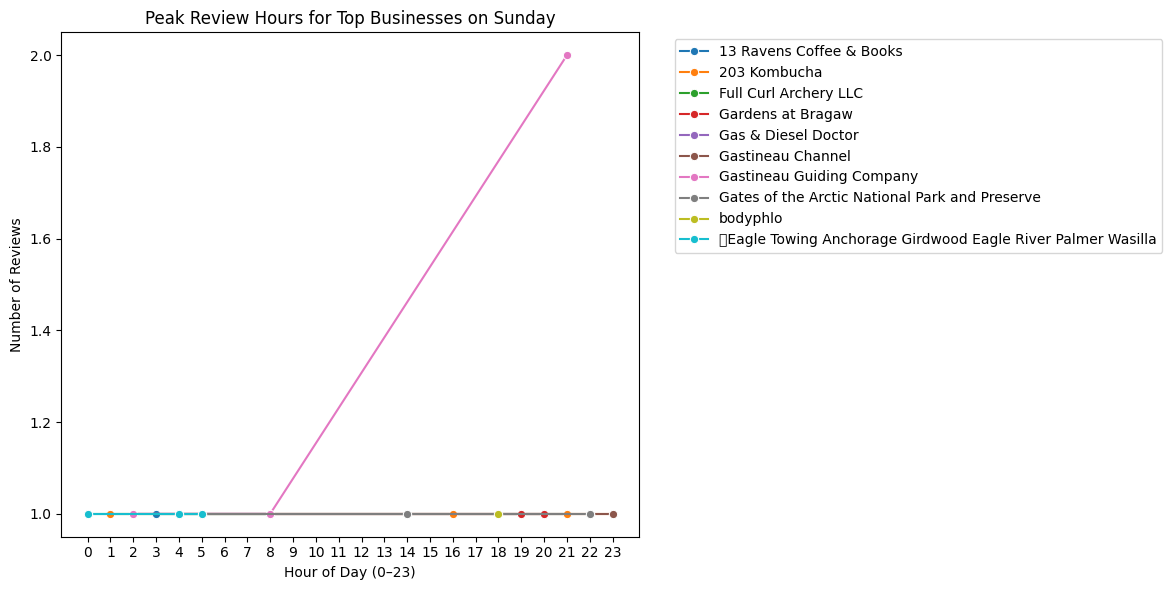


Peak review hours for each top business on Sunday
                                                       name                                                                                                                                                                                                                         category  hour  review_count
                                   13 Ravens Coffee & Books                                                                                                                                                                                            ['Coffee shop', 'Book store', 'Cafe']     3             1
                                               203 Kombucha                                                                                                                                                                                                                    ['Tea house']     1             1
                                  

In [15]:
# 1.3.3 Peak review hours for top businesses

# Extract review hour from datetime
pdf["hour"] = pdf["datetime"].dt.hour

# Filter for top weekday + top businesses
weekday_top_reviews = pdf[pdf["weekday"] == top_weekday].merge(meta_df, on="gmap_id", how="left")
weekday_top_reviews = weekday_top_reviews[weekday_top_reviews["name"].isin(top_business["name"].tolist())]

# Group by business + hour
hourly_reviews = (
    weekday_top_reviews.groupby(["name", "category", "hour"])["gmap_id"]
    .count()
    .reset_index(name="review_count")
)

# Plot line chart
plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_reviews, x="hour", y="review_count", hue="name", marker="o")
plt.xticks(range(0,24))
plt.title(f"Peak Review Hours for Top Businesses on {top_weekday}")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Peak hour summary table
peak_summary = (
    hourly_reviews.loc[hourly_reviews.groupby("name")["review_count"].idxmax()]
    [["name", "category", "hour", "review_count"]]
    .reset_index(drop=True)
)

print("\nPeak review hours for each top business on", top_weekday)
print(peak_summary.to_string(index=False))


### Q1.4

Top 30 Most Common Words Across All Reviews:

the: 267318
no: 235108
review: 224464
and: 223262
a: 145379
to: 141404
i: 107277
great: 82931
was: 82475
is: 82085
of: 80947
for: 77629
in: 73586
good: 64356
food: 63265
it: 60684
they: 54932
place: 47991
you: 46928
service: 45771
my: 45281
but: 43895
with: 41868
very: 40417
are: 40163
have: 38701
this: 37583
on: 35443
that: 33593
not: 32529


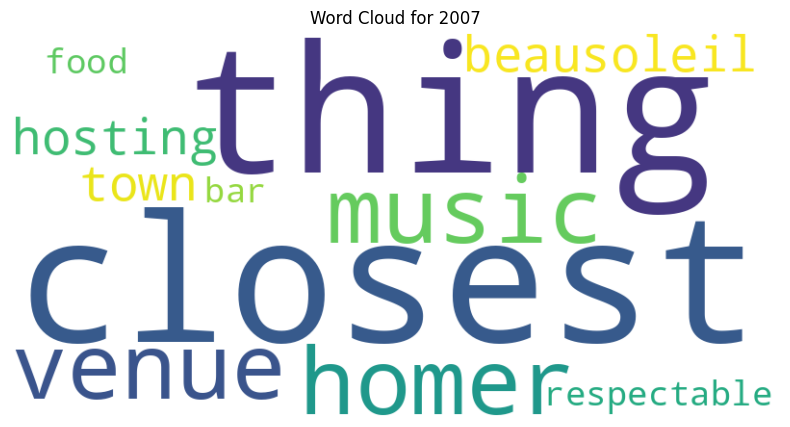

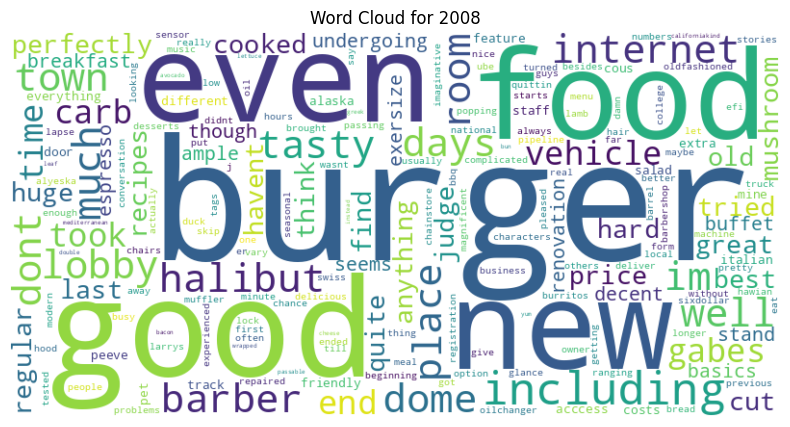

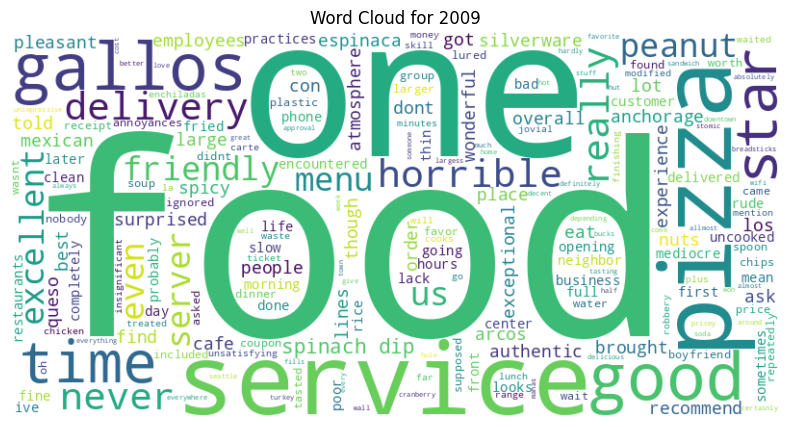

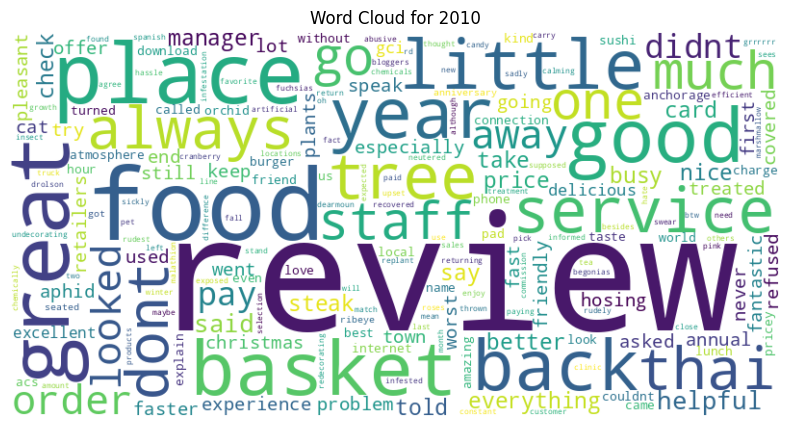

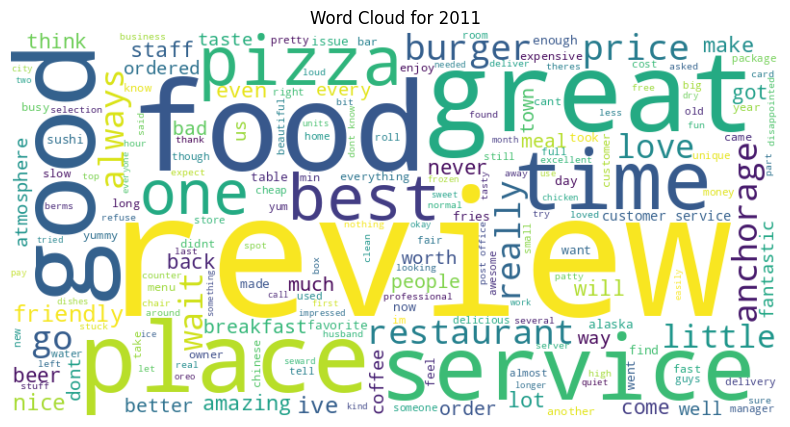

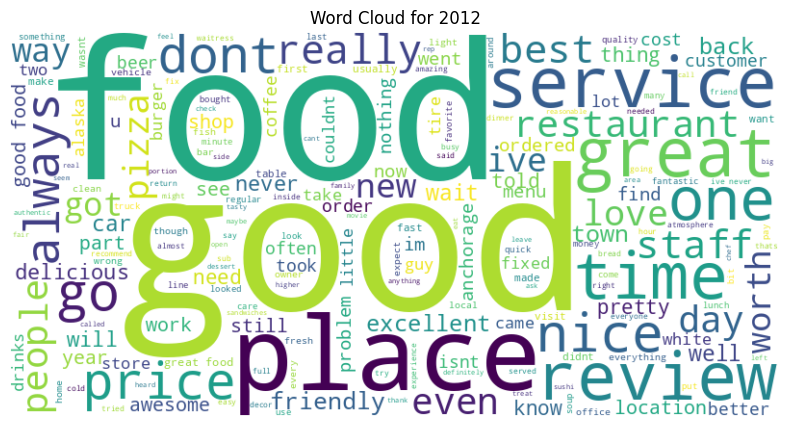

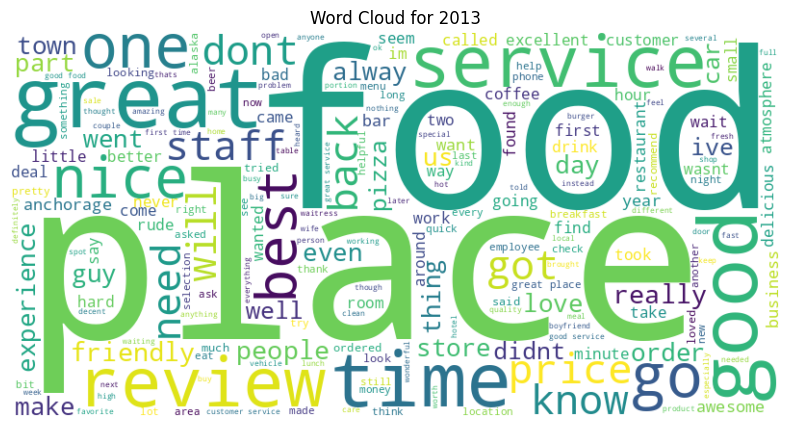

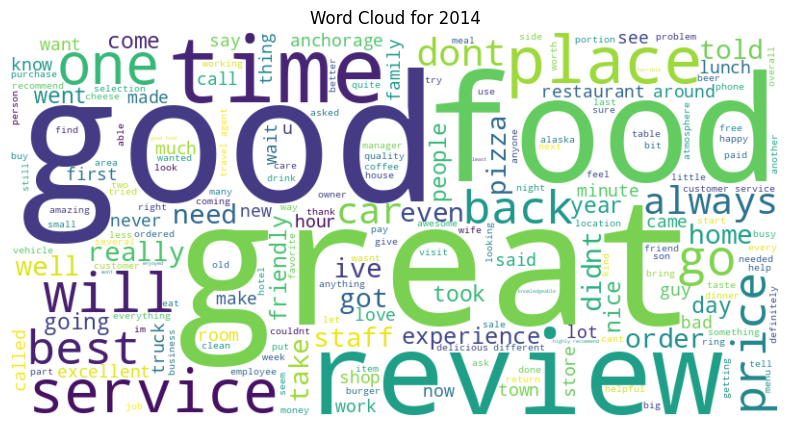

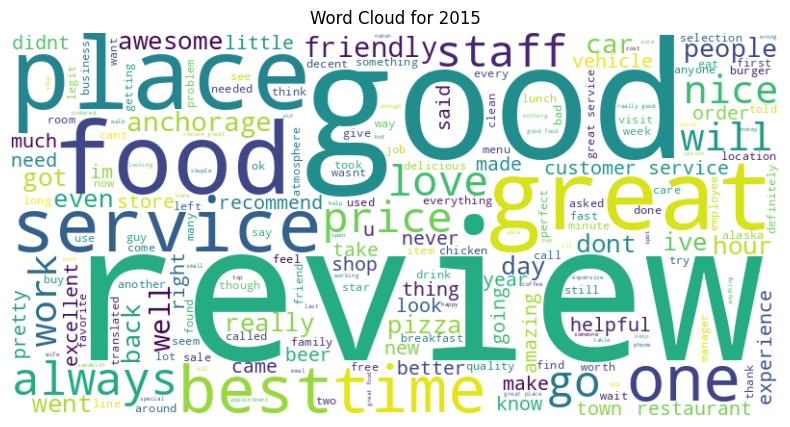

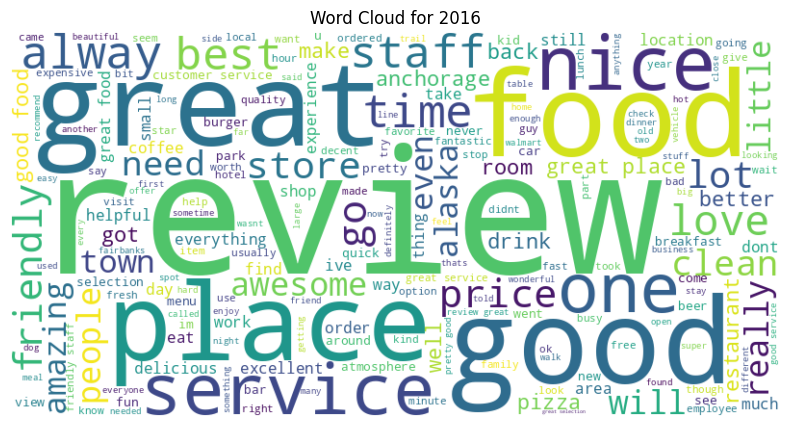

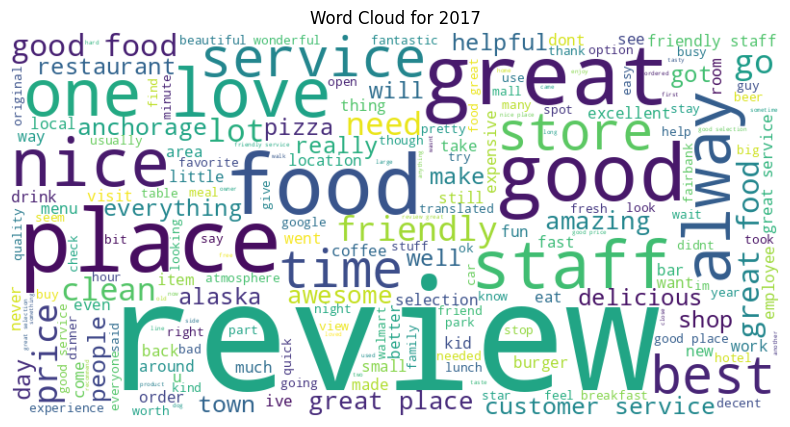

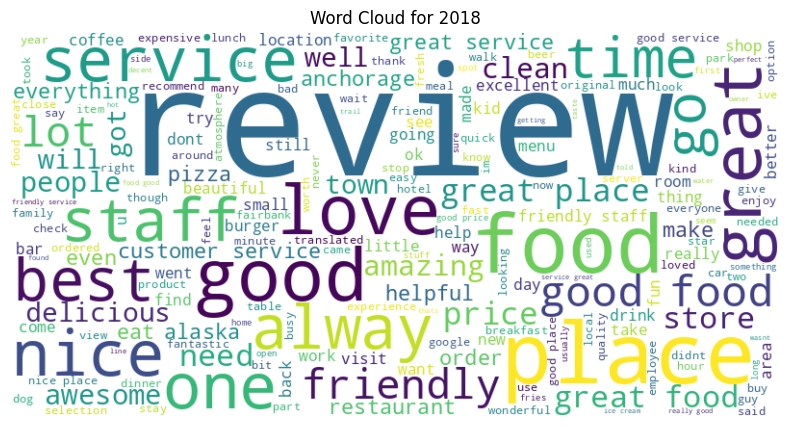

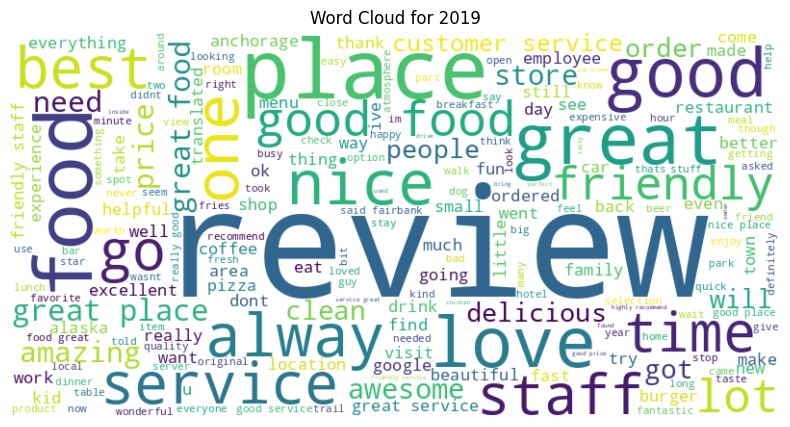

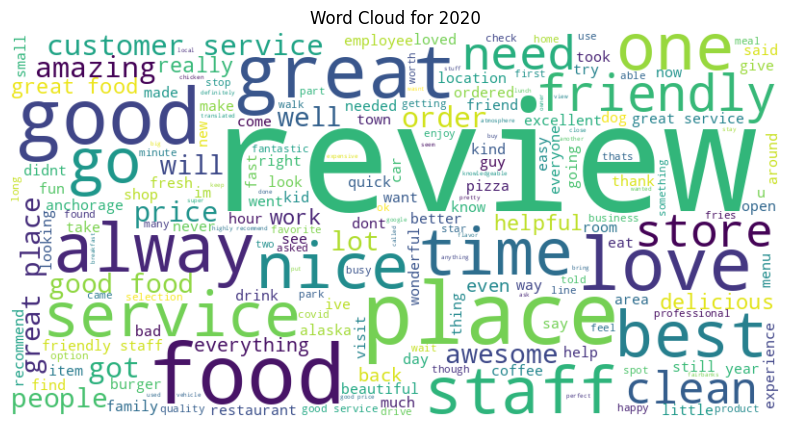

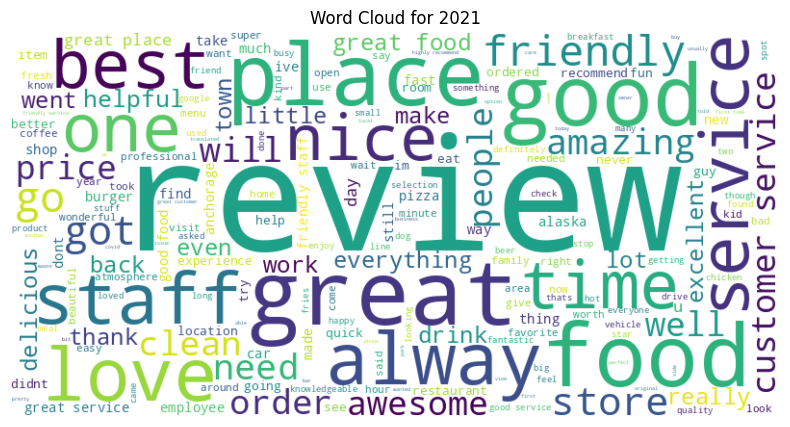

In [16]:
# Q1.4 Most Common Words + Word Clouds

from collections import Counter
from wordcloud import WordCloud
import re

# Clean text (remove NaN, lowercase, strip punctuation)
pdf["clean_text"] = (
    pdf["text"]
    .fillna("")
    .str.lower()
    .apply(lambda x: re.sub(r"[^a-z\s]", "", x))
)

# Top 30 most common words
all_words = " ".join(pdf["clean_text"]).split()
word_counts = Counter(all_words)
top_30_words = word_counts.most_common(30)

print("Top 30 Most Common Words Across All Reviews:\n")
for word, count in top_30_words:
    print(f"{word}: {count}")

# Extract review year
pdf["year"] = pdf["datetime"].dt.year

# Generate word clouds per year
year_groups = pdf.groupby("year")["clean_text"].apply(lambda x: " ".join(x))

for year, text in year_groups.items():
    if text.strip():  # only if there is text
        wc = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for {year}")
        plt.show()
